# **Sentiment analysis**

**Sentiment analysis**, also known as opinion mining, is a natural language processing (NLP) technique that identifies the emotional tone embedded within text. This methodology is widely used by organizations to evaluate and categorize public opinions regarding products, services, or concepts. It leverages data mining, machine learning, and artificial intelligence to analyze textual data for sentiment and subjective information.

Sentiment analysis systems enable organizations to derive meaningful insights from unstructured and unorganized text originating from various online sources, such as emails, blog posts, customer support tickets, web chats, social media platforms, forums, and user comments. These systems automate data processing using rule-based, automated, or hybrid methodologies. Rule-based approaches rely on predefined lexicon-based rules to perform sentiment classification, while automated systems utilize machine learning algorithms to infer sentiment from training data. Hybrid systems combine both rule-based and automated methods to enhance performance. Beyond determining sentiment, opinion mining can extract additional information, including polarity (the degree of positivity or negativity), subjects, and opinion holders. Moreover, sentiment analysis can be conducted at various granularities, including document, paragraph, sentence, and sub-sentence levels.



## **Types of Sentiment Analysis**

Sentiment analysis can be categorized into several types based on the level of granularity and the focus of the analysis:

* **Fine-Grained Sentiment Analysis**: This approach provides a detailed breakdown of sentiment polarity, typically on a scale from very positive to very negative. It mirrors the granularity of rating systems, such as a 5-star scale, offering precise insights into opinion strength.

* **Emotion Detection**: Unlike traditional polarity-focused methods, emotion detection identifies specific emotions within the text. Examples include happiness, frustration, shock, anger, and sadness, enabling a deeper understanding of emotional context.

* **Intent-Based Analysis**: This type of analysis extends beyond opinion to recognize the underlying actions or intentions within a text. For instance, a comment expressing frustration about replacing a battery may indicate a need for assistance, prompting customer service intervention to address the issue.

* **Aspect-Based Analysis**: Aspect-based sentiment analysis focuses on identifying sentiment tied to specific components or attributes of a subject. For example, a product review might mention dissatisfaction with battery life rather than the product as a whole. In such cases, the system attributes the negative sentiment specifically to the battery life aspect.

These specialized types of sentiment analysis allow for nuanced and actionable insights, tailored to different analytical needs and use cases.

**Import required libraries** for this Python project for Twitter sentiment analysis of hatred speech recognition.

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", color = "green", attrs = ["dark", "bold"]))


LIBRARIES WERE SUCCESFULLY IMPORTED...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset of Twitter hatred speech is avilable in the colab folder as train.csv and test.csv

### **Read the dataset files**

In [82]:
# Load the train and test datasets
try:
    train_set = pd.read_csv('/content/train.csv')
    test_set  = pd.read_csv('/content/test.csv')
    print("Datasets loaded successfully.")
    # Now you can work with train_df and test_df
    # Example: print the first 5 rows of the training data
    print(train_set.head())
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found in /content/. Please ensure they are uploaded correctly.")
except pd.errors.ParserError:
    print("Error: Could not parse the CSV files. Please check their format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Datasets loaded successfully.
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


In [83]:
train_set.head(n = 5).style.background_gradient(cmap = "summer")


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


Read the first five rows of test set

In [84]:
test_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


Shapes of the train and test sets

In [85]:
print("Train set shape: {} and test set shape: {}".format(train_set.shape, test_set.shape))

Train set shape: (31962, 3) and test set shape: (17197, 2)


Get general information about train set

In [86]:
print("Train set information" )
train_set.info()

print("\n\nTest set information")
test_set.info()

Train set information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


Test set information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


Check whether there are duplicated values

In [87]:
print("Totally there are {} duplicated values in train_set".format(train_set.duplicated().sum()))

Totally there are 0 duplicated values in train_set


Get the number of classes of the "label" variable of train set

In [88]:
train_set.groupby("label").count().style.background_gradient(cmap = "summer")

,id,tweet
label,,
0,29720,29720
1,2242,2242


In [89]:
# prompt: downsample the train_set with three columns (id,tweet,label) based on minority class 1

# Assuming 'train_set' DataFrame from the previous code is available.
# Downsample the majority class to match the minority class (label 1)

# Separate majority and minority classes
majority_class = train_set[train_set.label==0]
minority_class = train_set[train_set.label==1]

# Downsample majority class
majority_downsampled = majority_class.sample(n=len(minority_class), random_state=42)

# Combine minority class with downsampled majority class
downsampled_train = pd.concat([majority_downsampled, minority_class])

# Display the class distribution in the downsampled dataset
print(downsampled_train.label.value_counts())
train_set_copy = train_set.copy()
train_set = downsampled_train

label
0    2242
1    2242
Name: count, dtype: int64


### **Clean And Process Dataset**
1. Convert uppercase letters to lowercase letters in "tweet" column

In [90]:
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet"] = test_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nDELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DELETED SUCCESFULLY...


2. Delete punctuation marks from "tweet" columns

In [91]:
train_set["tweet"] = train_set["tweet"].str.replace('[^\w\s]','')
test_set["tweet"] = test_set["tweet"].str.replace('[^\w\s]','')
print(colored("\nDELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DELETED SUCCESFULLY...


3. Delete numbers from "tweet" columns

In [92]:
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')

print(colored("\n NUMBERS DELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


 NUMBERS DELETED SUCCESFULLY...


4. Delete stopwords from "tweet" columns

In [93]:
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

print(colored("\nSTOPWORDS DELETED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


STOPWORDS DELETED SUCCESFULLY...


5. Lemmatization. That is, we get the roots of the words in the "tweet" columns

In [94]:
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nDONE SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DONE SUCCESFULLY...


6. Drop "id" column from datasets

In [95]:
train_set = train_set.drop("id", axis = 1)
test_set = test_set.drop("id", axis = 1)

print(colored("\n'ID' COLUMNS DROPPED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


'ID' COLUMNS DROPPED SUCCESFULLY...


Look at the latest condition of train set

In [96]:
train_set.head(n = 10)

,label,tweet
8824,0,"#body body massage ending oil #massage ,body h..."
31854,0,@user @ call back! #casting #castingcall #mode...
28079,0,help creates #environment #togetherness &amp; ...
29214,0,summer friendâ¨ð¥ #summer #friend #life #vl...
20025,0,follow snapchat awesomecutenes7 #snapchat #sel...
21437,0,@user robbie told @user #thesmb lead asked bro...
24167,0,cupcakes! #beachpay #payplanning #friends #eno...
12833,0,happy boyð love guy #littleman #loveofmylif...
15840,0,keshi's news really hard accept. #sosudden
20134,0,day porn movie skinny amateur sex


In [97]:
test_set.head(n = 10)

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone see n...
2,safe way heal #acne!! #altwaystoheal #healthy ...
3,"hp cursed child book reservation already? yes,..."
4,"3rd #bihday amazing, hilarious #nephew eli ahm..."
5,choose :) #momtips
6,something inside dy ð¦ð¿â¨ eye ness #smok...
7,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8,@user @user @user never understand dad left yo...
9,#delicious #food #lovelife #capetown mannaepic...


In [109]:
# Using dataframe train_set: remove @user # 

import re

# Define a function to remove @user and # symbols
def remove_mentions_hashtags(text):
    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (#)
    text = re.sub(r'#', '', text)
    return text

# Apply the function to the 'tweet' column
train_set['cleaned_tweet'] = train_set['tweet'].apply(remove_mentions_hashtags)


In [110]:
# prompt: Using dataframe train_set: remove - . #

# Remove - . # from the 'cleaned_tweet' column
train_set['cleaned_tweet'] = train_set['cleaned_tweet'].str.replace('-', '', regex=False)
train_set['cleaned_tweet'] = train_set['cleaned_tweet'].str.replace('.', '', regex=False)
train_set['cleaned_tweet'] = train_set['cleaned_tweet'].str.replace('#', '', regex=False)

In [111]:
train_set.head(n = 10)

,label,tweet,cleaned_tweet
8824,0,"body body massage ending oil massage ,body hap...","body body massage ending oil massage ,body hap..."
31854,0,@ call back! casting castingcall model cute t...,@ call back! casting castingcall model cute t...
28079,0,help creates environment togetherness &amp; mu...,help creates environment togetherness &amp; mu...
29214,0,summer friendâ¨ð¥ summer friend life vlog w...,summer friendâ¨ð¥ summer friend life vlog w...
20025,0,follow snapchat awesomecutenes7 snapchat selfi...,follow snapchat awesomecutenes7 snapchat selfi...
21437,0,robbie told thesmb lead asked broadcast ble...,robbie told thesmb lead asked broadcast ble...
24167,0,cupcakes! beachpay payplanning friends enough ...,cupcakes! beachpay payplanning friends enough ...
12833,0,happy boyð love guy littleman loveofmylife ...,happy boyð love guy littleman loveofmylife ...
15840,0,keshi's news really hard accept. sosudden,keshi's news really hard accept sosudden
20134,0,day porn movie skinny amateur sex,day porn movie skinny amateur sex


In [112]:
test_set['cleaned_tweet'] = test_set['tweet'].apply(remove_mentions_hashtags)


In [113]:
test_set.head(n = 10)

,tweet,cleaned_tweet
0,studiolife aislife requires passion dedication...,studiolife aislife requires passion dedication...
1,white supremacists want everyone see new â ...,white supremacists want everyone see new â ...
2,safe way heal acne!! altwaystoheal healthy hea...,safe way heal acne!! altwaystoheal healthy hea...
3,"hp cursed child book reservation already? yes,...","hp cursed child book reservation already? yes,..."
4,"3rd bihday amazing, hilarious nephew eli ahmir...","3rd bihday amazing, hilarious nephew eli ahmir..."
5,choose :) momtips,choose :) momtips
6,something inside dy ð¦ð¿â¨ eye ness smoke...,something inside dy ð¦ð¿â¨ eye ness smoke...
7,finishedtattooinkedinkloveitâ¤ï¸ â¤ï¸â¤ï¸...,finishedtattooinkedinkloveitâ¤ï¸ â¤ï¸â¤ï¸...
8,never understand dad left young.... :/ deep...,never understand dad left young.... :/ deep...
9,delicious food lovelife capetown mannaepicure ...,delicious food lovelife capetown mannaepicure ...


In [114]:
# prompt: Using dataframe test_set: remove tweet colum and rename cleaned_tweet colum to tweet

# Drop the 'tweet' column
train_set = train_set.drop('tweet', axis=1)
test_set = test_set.drop('tweet', axis=1)

# Rename the 'cleaned_tweet' column to 'tweet'
train_set = train_set.rename(columns={'cleaned_tweet': 'tweet'})
test_set = test_set.rename(columns={'cleaned_tweet': 'tweet'})


In [115]:
train_set.head(n = 10)

,label,tweet
8824,0,"body body massage ending oil massage ,body hap..."
31854,0,@ call back! casting castingcall model cute t...
28079,0,help creates environment togetherness &amp; mu...
29214,0,summer friendâ¨ð¥ summer friend life vlog w...
20025,0,follow snapchat awesomecutenes7 snapchat selfi...
21437,0,robbie told thesmb lead asked broadcast ble...
24167,0,cupcakes! beachpay payplanning friends enough ...
12833,0,happy boyð love guy littleman loveofmylife ...
15840,0,keshi's news really hard accept sosudden
20134,0,day porn movie skinny amateur sex


In [116]:
train_set_copy = train_set.copy()
test_set_copy = test_set.copy()

test_set.head(n = 10)

,tweet
0,studiolife aislife requires passion dedication...
1,white supremacists want everyone see new â ...
2,safe way heal acne!! altwaystoheal healthy hea...
3,"hp cursed child book reservation already? yes,..."
4,"3rd bihday amazing, hilarious nephew eli ahmir..."
5,choose :) momtips
6,something inside dy ð¦ð¿â¨ eye ness smoke...
7,finishedtattooinkedinkloveitâ¤ï¸ â¤ï¸â¤ï¸...
8,never understand dad left young.... :/ deep...
9,delicious food lovelife capetown mannaepicure ...


Divide datasets

In [117]:
x = train_set["tweet"]
y = train_set["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

print(colored("\nDIVIDED SUCCESFULLY...", color = "green", attrs = ["dark", "bold"]))


DIVIDED SUCCESFULLY...


In [106]:
train_x_copy, test_x_copy, train_y_copy, test_y_copy = train_x, test_x, train_y, test_y

### **Visualization**

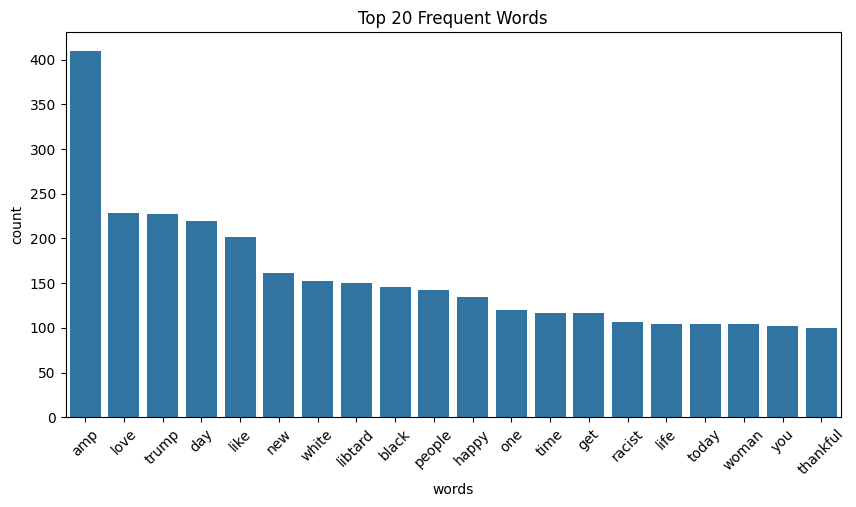

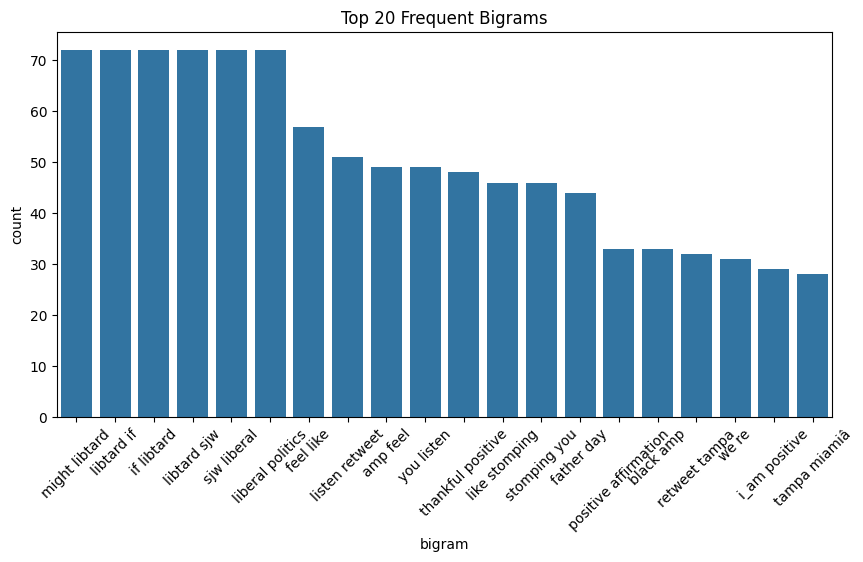

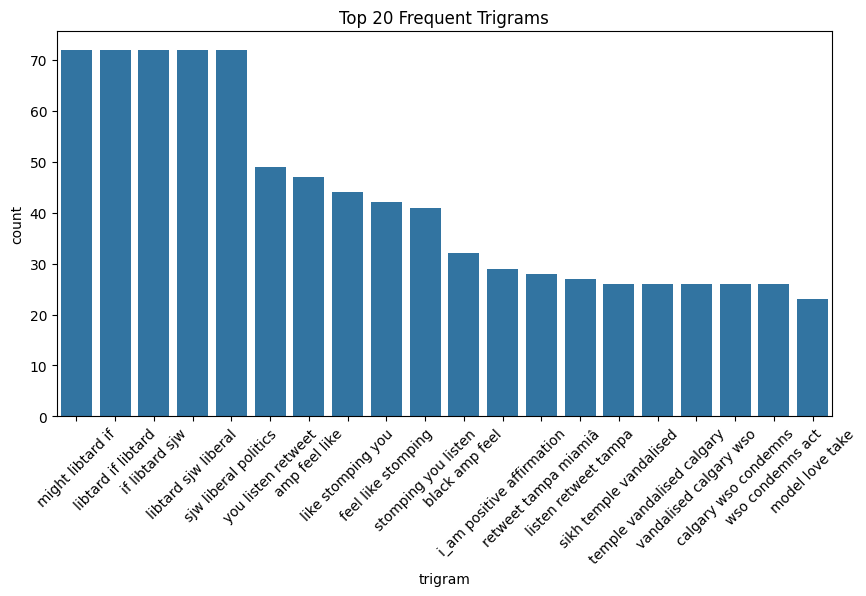

In [119]:
#Generate several Visualizations for the train_set Unigram Analysis, Bigram, and Trigram Analysis

import seaborn as sns
from collections import defaultdict

# Unigram Analysis
def plot_top_n_words(corpus, top_n=20):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_n], columns=['words', 'count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='words', y='count', data=top_df)
    plt.title(f'Top {top_n} Frequent Words')
    plt.xticks(rotation=45)
    plt.show()


plot_top_n_words(train_set['tweet'])


# Bigram Analysis
def plot_top_n_bigrams(corpus, top_n=20):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_n], columns=['bigram', 'count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='bigram', y='count', data=top_df)
    plt.title(f'Top {top_n} Frequent Bigrams')
    plt.xticks(rotation=45)
    plt.show()

plot_top_n_bigrams(train_set['tweet'])


# Trigram Analysis
def plot_top_n_trigrams(corpus, top_n=20):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_n], columns=['trigram', 'count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='trigram', y='count', data=top_df)
    plt.title(f'Top {top_n} Frequent Trigrams')
    plt.xticks(rotation=45)
    plt.show()

plot_top_n_trigrams(train_set['tweet'])

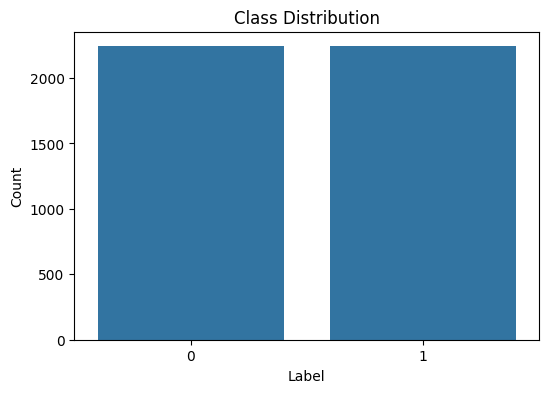

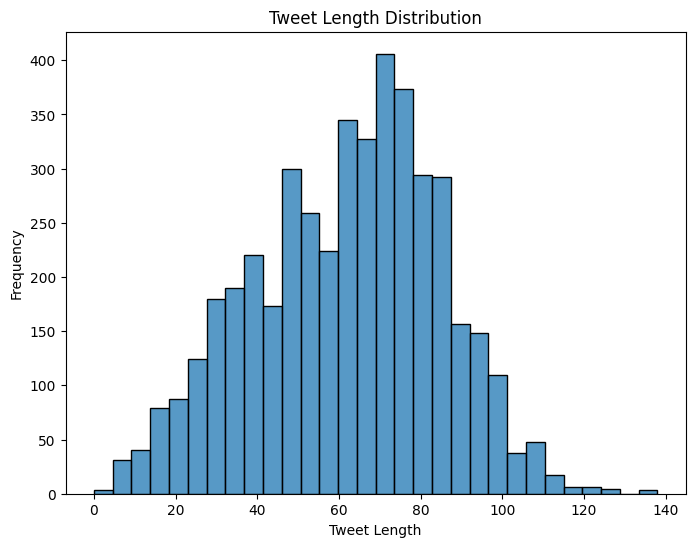

In [124]:
# Generate several Visualizations for the train_set Sentiment Analysis Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# 'train_set' DataFrame from the previous code is available.


# Class Distribution Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_set)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


# Tweet Length Distribution Visualization
train_set['tweet_length'] = train_set['tweet'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(train_set['tweet_length'], bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

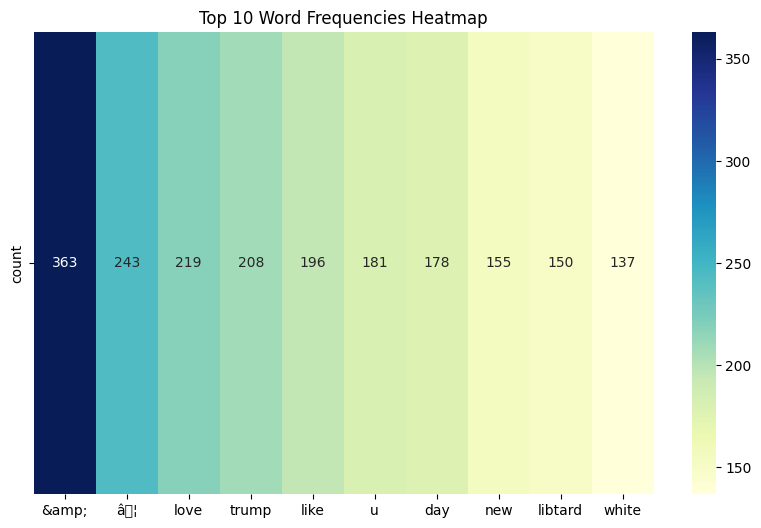

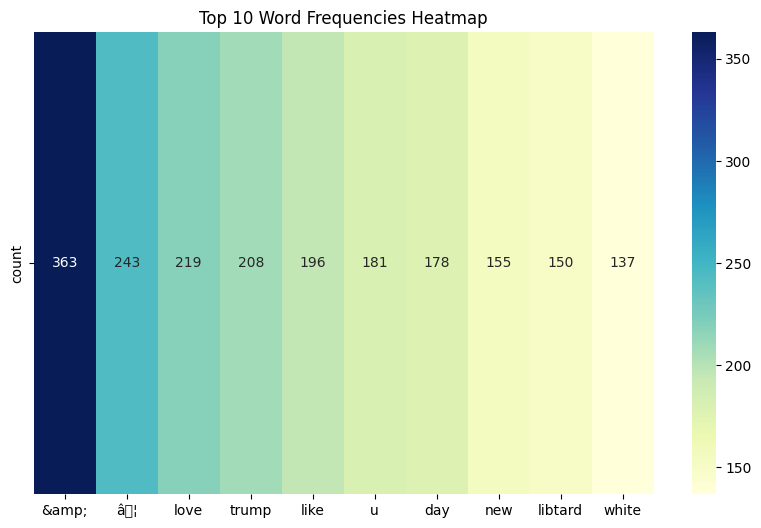

In [123]:
# prompt: Generate several Visualizations for the train_set Word Frequency Heatmaps

import matplotlib.pyplot as plt
import seaborn as sns

def plot_word_frequency_heatmap(df, num_words=10):
    # Calculate word frequencies
    word_freq = pd.Series(' '.join(df['tweet']).split()).value_counts()[:num_words]

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(word_freq).T, annot=True, cmap="YlGnBu", fmt='g')
    plt.title(f'Top {num_words} Word Frequencies Heatmap')
    plt.show()

plot_word_frequency_heatmap(train_set)
plot_word_frequency_heatmap(train_set, num_words=10) # Example with fewer words

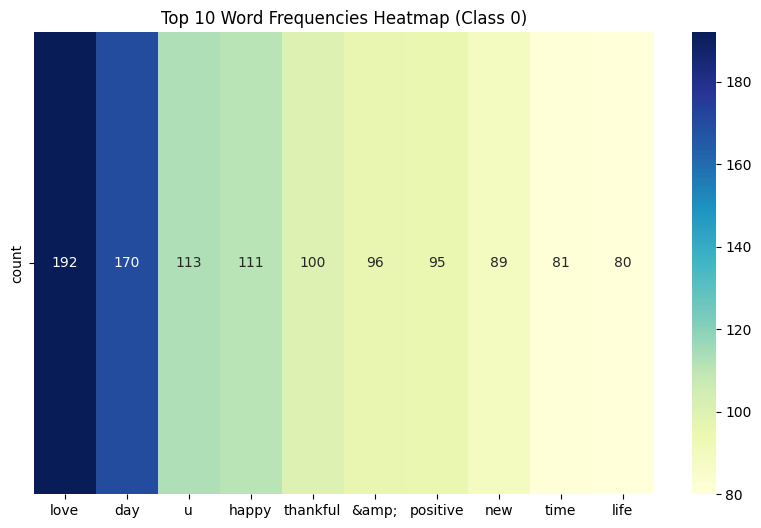

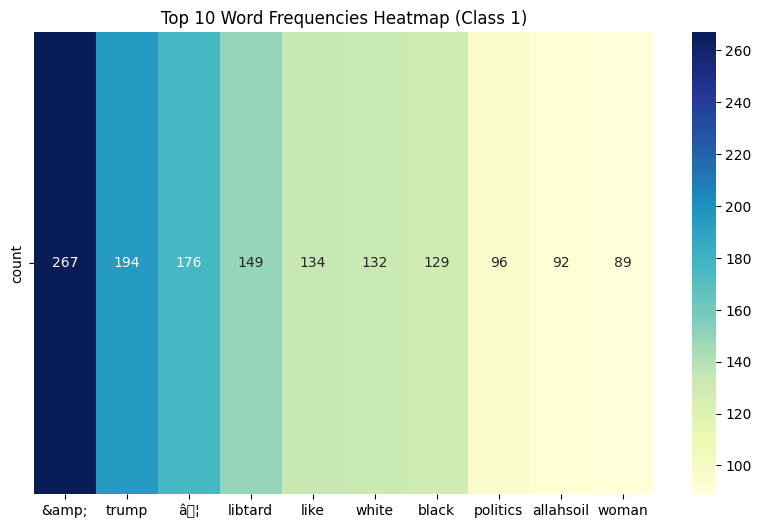

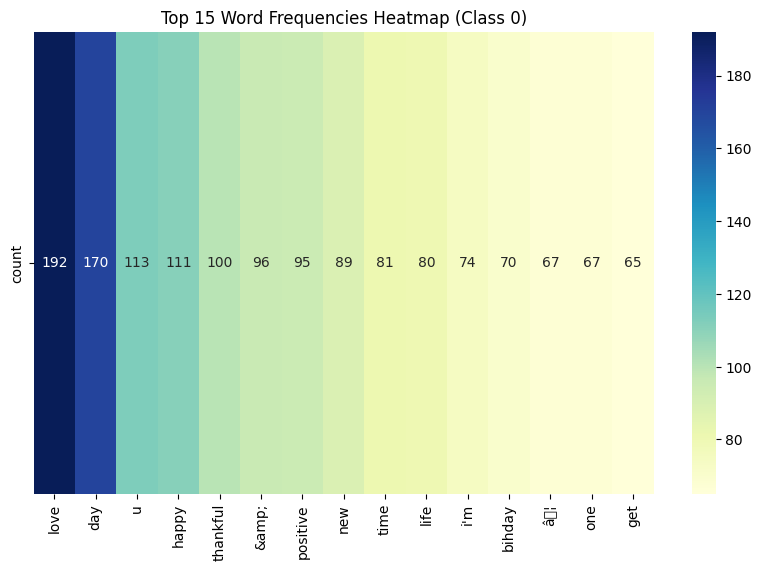

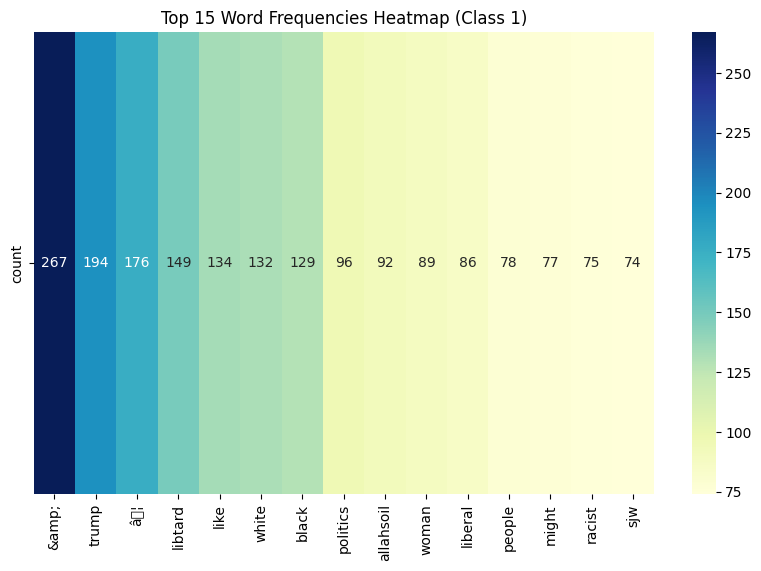

In [130]:
# prompt: Generate several Visualizations for the train_set Word Frequency Heatmaps for the two classes

def plot_word_frequency_heatmap_by_class(df, num_words=10):
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        word_freq = pd.Series(' '.join(subset['tweet']).split()).value_counts()[:num_words]
        plt.figure(figsize=(10, 6))
        sns.heatmap(pd.DataFrame(word_freq).T, annot=True, cmap="YlGnBu", fmt='g')
        plt.title(f'Top {num_words} Word Frequencies Heatmap (Class {label})')
        plt.show()

plot_word_frequency_heatmap_by_class(train_set)
plot_word_frequency_heatmap_by_class(train_set, num_words=15)

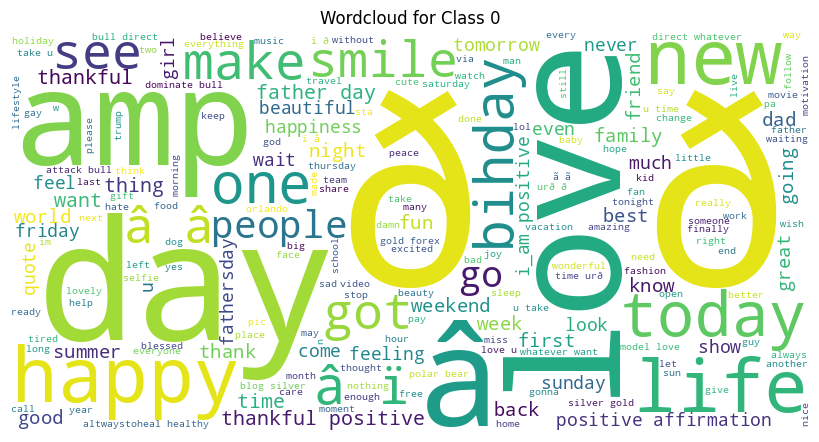

In [129]:
# prompt: Generate word cloud for both classes  Visualizations in the train_set

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Function to generate word cloud for a specific class
def generate_wordcloud(df, label):
    text = " ".join(review for review in df[df['label'] == label]['tweet'])
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          stopwords=STOPWORDS,
                          min_font_size=10).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Wordcloud for Class {label}")
    plt.show()


# Generate word clouds for both classes
generate_wordcloud(train_set, 0)


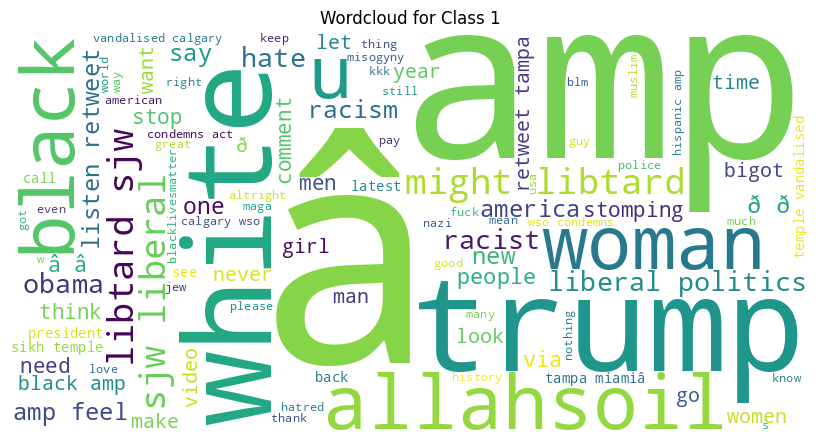

In [127]:
generate_wordcloud(train_set, 1)

### **"Count Vectors" method**

In [68]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

###**"TF-IDF" method**

In [69]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### **Build Machine Learning Models**



Logistic regression model with "count-vectors" method

In [ ]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (log_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (log_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (log_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\nLogistic regression model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


Logistic regression model with 'count-vectors' method
Accuracy ratio:  0.803838383838384
precision ratio:  0.8450855611536727
recall ratio:  0.7358225108225108
F1 ratio:  0.7824431145928966


Logistic regression model with "tf-idf" method

In [ ]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (log_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (log_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (log_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\nLogistic regression model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)



Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.8205808080808081
precision ratio:  0.8467425802163315
recall ratio:  0.7728354978354979
F1 ratio:  0.804950010306352


In [79]:
dtc = DecisionTreeClassifier()
dtc_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(dtc_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (dtc_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (dtc_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (dtc_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n Decision Tree Classifier model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 Decision Tree Classifier model with 'count-vectors' method
Accuracy ratio:  0.803838383838384
precision ratio:  0.8450855611536727
recall ratio:  0.7358225108225108
F1 ratio:  0.7824431145928966


In [80]:
dtc = DecisionTreeClassifier()
dtc_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(dtc_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (dtc_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (dtc_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (dtc_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n DecisionTreeClassifier model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)



 DecisionTreeClassifier model with 'tf-idf' method
Accuracy ratio:  0.8205808080808081
precision ratio:  0.8467425802163315
recall ratio:  0.7728354978354979
F1 ratio:  0.804950010306352


XGBoost model with "count-vectors" method

In [ ]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (xgb_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (xgb_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (xgb_model,
                                           x_test_count,
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n XGBClassifier model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 XGBClassifier model with 'count-vectors' method
Accuracy ratio:  0.7458838383838384
precision ratio:  0.8125233662965862
recall ratio:  0.6274891774891774
F1 ratio:  0.7046498716374378


XGBoost model with "tf-idf" method

In [ ]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (xgb_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (xgb_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (xgb_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='f1').mean()
print(colored("\nXGBoost model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


XGBoost model with 'tf-idf' method
Accuracy ratio:  0.7357575757575756
precision ratio:  0.7943658770709854
recall ratio:  0.6253246753246753
F1 ratio:  0.6946148624140683


Light GBM model with "count-vectors" method

In [70]:
lgbm = LGBMClassifier(verbosity=-1)
lgbm_model = lgbm.fit(x_train_count.astype("float64"), train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_count.astype("float64"),
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (lgbm_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (lgbm_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (lgbm_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n LGBMClassifier model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 LGBMClassifier model with 'count-vectors' method
Accuracy ratio:  0.657550505050505
precision ratio:  0.8423076119786647
recall ratio:  0.3718614718614719
F1 ratio:  0.5069276018170183


Light GBM model with "tf-idf" method

In [71]:
lgbm = LGBMClassifier(verbosity=-1)
lgbm_model = lgbm.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

precision =  model_selection.cross_val_score (lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n LGBMClassifier model with 'tf_idf' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 LGBMClassifier model with 'tf_idf' method
Accuracy ratio:  0.6564646464646465
precision ratio:  0.8135875820086346
recall ratio:  0.3856060606060606
F1 ratio:  0.5160298294908208


In [72]:
rfc = ensemble.RandomForestClassifier()
rfc_model = rfc.fit(x_train_count.astype("float64"), train_y)
accuracy = model_selection.cross_val_score(rfc_model,
                                           x_test_count.astype("float64"),
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (rfc_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (rfc_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (rfc_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n RandomForestClassifier model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 RandomForestClassifier model with 'count-vectors' method
Accuracy ratio:  0.7638131313131313
precision ratio:  0.8704362753259811
recall ratio:  0.618831168831169
F1 ratio:  0.7220097733461398


In [74]:
rfc = ensemble.RandomForestClassifier()
rfc_model = rfc.fit(x_train_count.astype("float64"), train_y)
accuracy = model_selection.cross_val_score(rfc_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (rfc_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (rfc_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (rfc_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n RandomForestClassifier model with 'tf_idf' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 RandomForestClassifier model with 'tf_idf' method
Accuracy ratio:  0.7716161616161616
precision ratio:  0.869667717903012
recall ratio:  0.6304112554112554
F1 ratio:  0.7304576505154169


Ada Boost Classifier

In [76]:
Ada = ensemble.AdaBoostClassifier()
Ada_model = rfc.fit(x_train_count.astype("float64"), train_y)
accuracy = model_selection.cross_val_score(Ada_model,
                                           x_test_count.astype("float64"),
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (Ada_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (Ada_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (Ada_model,
                                           x_test_count.astype("float64"),
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n AdaBoost Classifier model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 AdaBoost Classifier model with 'count-vectors' method
Accuracy ratio:  0.7626515151515152
precision ratio:  0.8616002831018312
recall ratio:  0.6053030303030303
F1 ratio:  0.7155976477389676


In [77]:
Ada = ensemble.AdaBoostClassifier()
Ada_model = Ada.fit(x_train_count.astype("float64"), train_y)
accuracy = model_selection.cross_val_score(Ada_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y,
                                           cv = 20).mean()
precision =  model_selection.cross_val_score (Ada_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y, cv = 20, scoring='precision').mean()
recall =  model_selection.cross_val_score (Ada_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y, cv = 20, scoring='recall').mean()

f1 =  model_selection.cross_val_score (Ada_model,
                                           x_test_tf_idf_word.astype("float64"),
                                           test_y, cv = 20, scoring='f1').mean()

print(colored("\n AdaBoostClassifier model with 'tf_idf' method", color = "red", attrs = ["dark", "bold"]))
print("Accuracy ratio: ", accuracy)
print("precision ratio: ", precision)
print("recall ratio: ", recall)
print("F1 ratio: ", f1)


 AdaBoostClassifier model with 'tf_idf' method
Accuracy ratio:  0.7245454545454544
precision ratio:  0.8469729535170712
recall ratio:  0.5335497835497834
F1 ratio:  0.6475895376088874


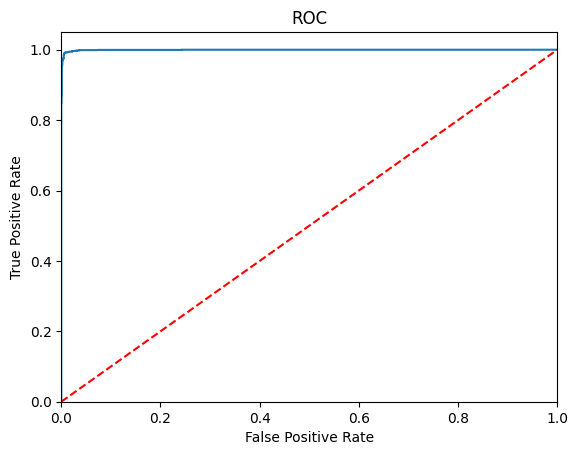

In [75]:
y = train_y
X = x_train_count.astype("float64")

logit_roc_auc = roc_auc_score(y, log_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, log_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

### **Estimation Over Test Set**

Look at the first 5 rows of the test set

In [ ]:
test_set.head()


,tweet
0,studiolife aislife requires passion dedication...
1,white supremacists want everyone see new â ...
2,safe way heal acne!! altwaystoheal healthy hea...
3,"hp cursed child book reservation already? yes,..."
4,"3rd bihday amazing, hilarious nephew eli ahmir..."


In [ ]:
test_set.shape

(17197, 1)

encode values of "tweet" column of test set with "count-vectors" method.

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
test_set = vectorizer.transform(test_set["tweet"])
test_set.toarray()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
lgbm_model.predict(test_set.astype("float"))[0:5]


array([0, 1, 0, 0, 0])

In [ ]:
train_set

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunc...
1,0,thanks lyft credit can't use cause offer whe...
2,0,bihday majesty
3,0,model love u take u time urð±!!! ððð...
4,0,factsguide: society motivation
...,...,...
31957,0,ate isz youuu?ðððððððð...
31958,0,see nina turner airwave trying wrap mantle gen...
31959,0,listening sad song monday morning otw work sad
31960,1,"sikh temple vandalised calgary, wso condemns act"


In [ ]:
test_set

<17197x35460 sparse matrix of type '<class 'numpy.int64'>'
	with 117860 stored elements in Compressed Sparse Row format>

###**Visualization with Word Cloud**

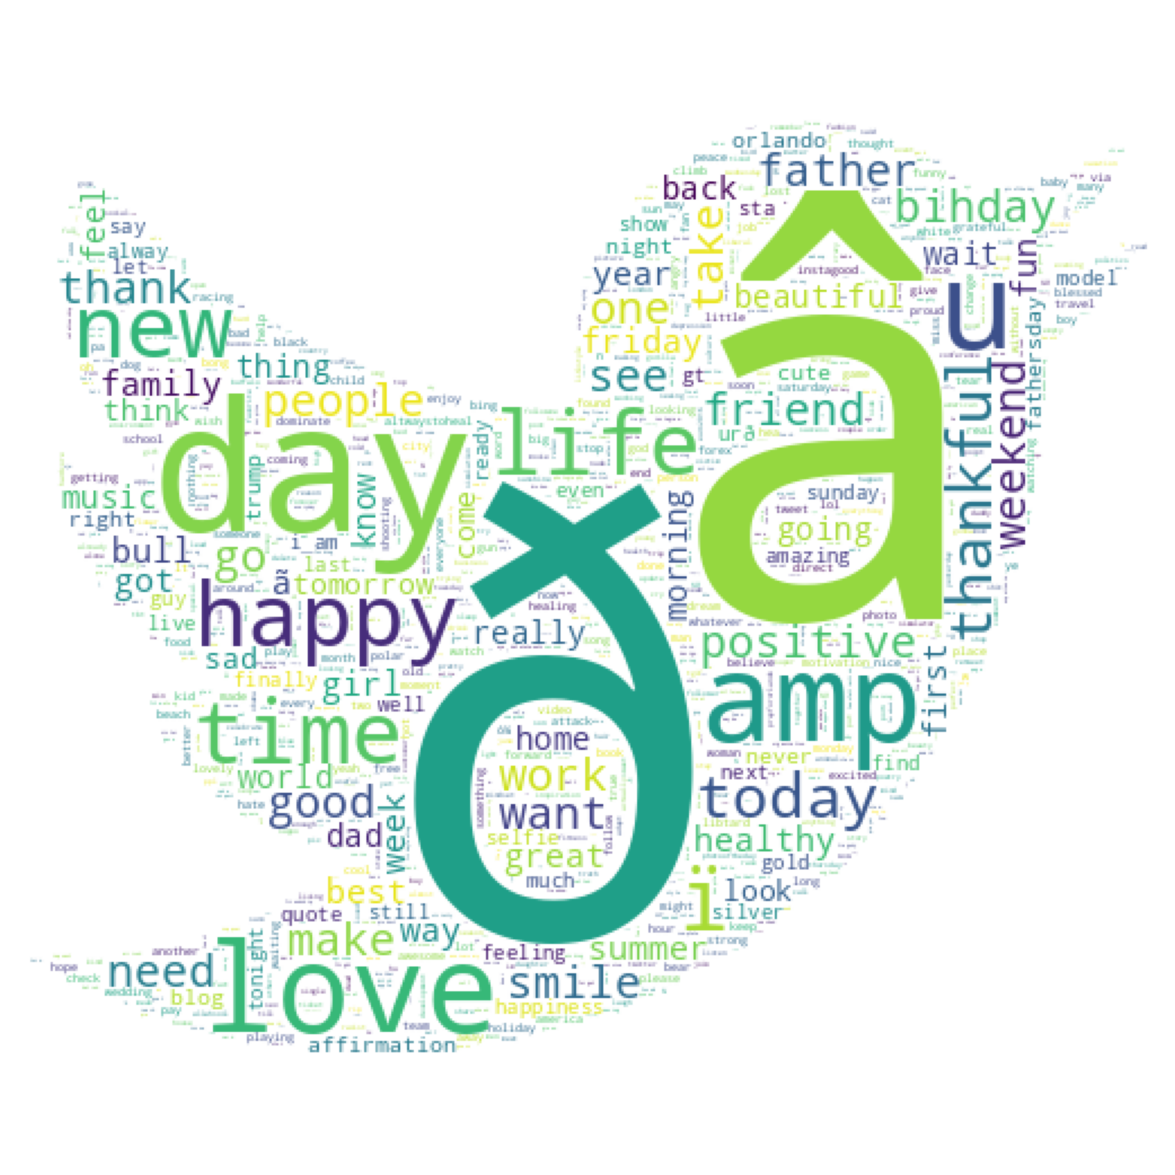

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
tw_mask = np.array(Image.open('/content/twitter_mask.jpg'))

text = " ".join(i for i in train_set.tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = tw_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.axis("off")
plt.show;

In [ ]:
train_x, test_x, train_y, test_y = train_x_copy, test_x_copy, train_y_copy, test_y_copy

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Update the import for Keras backend (K)
# from tensorflow import keras
# from keras import backend as K
from tensorflow import keras
# Use tf.keras.backend instead of keras.backend
from tensorflow.keras import backend as K

# ... (rest of your code remains the same) ...

def recall_m(y_true, y_pred):
    # Cast y_true to float32 to match y_pred's type
    y_true = tf.cast(y_true, dtype=tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    # Cast y_true to float32 to match y_pred's type
    y_true = tf.cast(y_true, dtype=tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    # Cast y_true to float32 to match y_pred's type
    y_true = tf.cast(y_true, dtype=tf.float32)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming train_x, test_x, train_y, test_y are defined as in the provided code

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)  # Adjust num_words as needed
tokenizer.fit_on_texts(train_x)

train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

# Pad sequences to have the same length
max_sequence_length = 300  # Adjust as needed
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 128, input_length=max_sequence_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# Train the model
model.fit(train_padded, train_y, epochs=30, validation_data=(test_padded, test_y))  # Adjust epochs as needed

# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(test_padded, test_y)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test precision: {precision:.4f}')
print(f'Test recall: {recall:.4f}')
print(f'Test f1 score: {f1_score:.4f}')

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - acc: 0.5047 - f1_m: 0.3319 - loss: 0.6952 - precision_m: 0.2502 - recall_m: 0.5028 - val_acc: 0.4849 - val_f1_m: 0.6609 - val_loss: 0.6949 - val_precision_m: 0.5022 - val_recall_m: 1.0000
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - acc: 0.4953 - f1_m: 0.5432 - loss: 0.6937 - precision_m: 0.4092 - recall_m: 0.8194 - val_acc: 0.5151 - val_f1_m: 0.0000e+00 - val_loss: 0.6930 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 229ms/step - acc: 0.4948 - f1_m: 0.2153 - loss: 0.6934 - precision_m: 0.1638 - recall_m: 0.3204 - val_acc: 0.5151 - val_f1_m: 0.0000e+00 - val_loss: 0.6930 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - acc: 0.4786 - f1_m: 0.3951 - loss: 0.6936 - precision_m: 0.2967 - recall_m: 0.6020 - val_acc: 0.4849 - val_f1_m: 0.6609 - val_loss: 0.6934 - val_precision_m: 0.5022 - val_recall_m: 1.0

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)  # Adjust num_words as needed
tokenizer.fit_on_texts(train_x)

train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

# Pad sequences to have the same length
max_sequence_length = 300  # Adjust as needed
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Define the biLSTM model with at least 4 layers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 128, input_length=max_sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), #First BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), #Second BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)), #Third BiLSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)), #Fourth BiLSTM layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# Train the model
model.fit(train_padded, train_y, epochs=30, batch_size=32, validation_data=(test_padded, test_y))  # Adjust epochs and batch_size as needed

# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(test_padded, test_y)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test precision: {precision:.4f}')
print(f'Test recall: {recall:.4f}')
print(f'Test f1 score: {f1_score:.4f}')

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - acc: 0.5972 - f1_m: 0.5217 - loss: 0.6356 - precision_m: 0.5146 - recall_m: 0.6376 - val_acc: 0.8138 - val_f1_m: 0.8326 - val_loss: 0.4341 - val_precision_m: 0.7560 - val_recall_m: 0.9424
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - acc: 0.9162 - f1_m: 0.9131 - loss: 0.2515 - precision_m: 0.9169 - recall_m: 0.9191 - val_acc: 0.8462 - val_f1_m: 0.8454 - val_loss: 0.4053 - val_precision_m: 0.8364 - val_recall_m: 0.8672
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - acc: 0.9628 - f1_m: 0.9611 - loss: 0.1270 - precision_m: 0.9692 - recall_m: 0.9555 - val_acc: 0.8540 - val_f1_m: 0.8477 - val_loss: 0.4144 - val_precision_m: 0.8503 - val_recall_m: 0.8563
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - acc: 0.9822 - f1_m: 0.9824 - loss: 0.0692 - precision_m: 0.9825 - recall_m: 0.9837 - val_acc: 0.8506 - val_f1_m: 0.8414 - val_loss: 0.4525 - val_precision_m: 0.8611 - val_recall_m: 0.8342
Epoch 5/30
113/113 ━━━━━━━━━